# CHAPTER 05 몬테카를로 방법

## 5.1 몬테카를로 예측 (블랙잭)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
# actions: hit or stand
ACTION_HIT = 0
ACTION_STAND = 1 # "strike" in the book
ACTIONS = [ACTION_HIT, ACTION_STAND]

In [3]:
# policy for player
POLICY_PLAYER = np.zeros(22, dtype=np.int)
for i in range(12, 20):
    POLICY_PLAYER[i] = ACTION_HIT
POLICY_PLAYER[20] = POLICY_PLAYER[21] = ACTION_STAND

In [4]:
# function form of target policy of player
def target_policy_player(useable_ace_palyer, player_sum, dealer_card):
    return POLICY_PLAYER[player_sum]

# function form of behavior policy of player
def behavior_policy_player(useable_ace_palyer, player_sum, dealer_card):
    if np.random.binomial(1, 0.5) == 1:
        return ACTION_STAND
    return ACTION_HIT

In [5]:
# policy for dealer
POLICY_DEALER = np.zeros(22)
for i in range(12, 17):
    POLICY_DEALER[i] = ACTION_HIT
for i in range(17, 22):
    POLICY_DEALER[i] = ACTION_STAND

In [6]:
# get a new card
def get_card():
    card = np.random.randint(1, 14)
    card = min(card, 10)
    return card

# get the value of card (11 for ace).
def card_value(card_id):
    return 11 if card_id == 1 else card_id

In [7]:
# play a game
# @policy_player: specify policy for player
# @initial_state: [whether player has a usable Ace, sum of player's cards, one card of dealer]
# @initial_action: the initial action
def play(policy_player):
    # sum of player
    player_sum = 0

    # trajectory of player
    player_trajectory = []

    # whether player uses Ace as 11
    usable_ace_player = False

    # dealer status
    dealer_card1 = 0
    dealer_card2 = 0
    usable_ace_dealer = False

    # generate a random initial state
    while player_sum < 12:
        # if sum of player is less than 12, always hit
        card = get_card()
        player_sum += card_value(card)

        # If the player's sum is larger than 21, he may hold one or two aces.
        if player_sum > 21:
            assert player_sum == 22
            # last card must be ace
            player_sum -= 10
        else:
            usable_ace_player |= (1 == card)

    # initialize cards of dealer, suppose dealer will show the first card he gets
    dealer_card1 = get_card()
    dealer_card2 = get_card()

    # initial state of the game
    state = [usable_ace_player, player_sum, dealer_card1]

    # initialize dealer's sum
    dealer_sum = card_value(dealer_card1) + card_value(dealer_card2)
    usable_ace_dealer = 1 in (dealer_card1, dealer_card2)
    # if the dealer's sum is larger than 21, he must hold two aces.
    if dealer_sum > 21:
        assert dealer_sum == 22
        # use one Ace as 1 rather than 11
        dealer_sum -= 10
    assert dealer_sum <= 21
    assert player_sum <= 21

    # game starts!

    # player's turn
    while True:
        # get action based on current sum
        action = policy_player(usable_ace_player, player_sum, dealer_card1)

        # track player's trajectory for importance sampling
        player_trajectory.append([(usable_ace_player, player_sum, dealer_card1), action])

        if action == ACTION_STAND:
            break
    
        # if hit, get new card
        card = get_card()
        # Keep track of the ace count. the usable_ace_player flag is insufficient alone as it cannot
        # distinguish between having one ace or two.
        ace_count = int(usable_ace_player)
        if card == 1:
            ace_count += 1
        player_sum += card_value(card)
        # If the player has a usable ace, use it as 1 to avoid busting and continue.
        while player_sum > 21 and ace_count:
            player_sum -= 10
            ace_count -= 1
        # player busts
        if player_sum > 21:
            return state, -1, player_trajectory
        assert player_sum <= 21
        usable_ace_player = (ace_count == 1)

    # dealer's turn
    while True:
        # get action based on current sum
        action = POLICY_DEALER[dealer_sum]
        if action == ACTION_STAND:
            break
        # if hit, get a new card
        new_card = get_card()
        ace_count = int(usable_ace_dealer)
        if new_card == 1:
            ace_count += 1
        dealer_sum += card_value(new_card)
        # If the dealer has a usable ace, use it as 1 to avoid busting and continue.
        while dealer_sum > 21 and ace_count:
            dealer_sum -= 10
            ace_count -= 1
        # dealer busts
        if dealer_sum > 21:
            return state, 1, player_trajectory
        usable_ace_dealer = (ace_count == 1)

    # compare the sum between player and dealer
    assert player_sum <= 21 and dealer_sum <= 21
    if player_sum > dealer_sum:
        return state, 1, player_trajectory
    elif player_sum == dealer_sum:
        return state, 0, player_trajectory
    else:
        return state, -1, player_trajectory

In [8]:
# Monte Carlo Sample with On-Policy
def monte_carlo_on_policy(episodes):
    states_usable_ace = np.zeros((10, 10))
    # initialize counts to 1 to avoid 0 being divided
    states_usable_ace_count = np.ones((10, 10))
    states_no_usable_ace = np.zeros((10, 10))
    # initialize counts to 1 to avoid 0 being divided
    states_no_usable_ace_count = np.ones((10, 10))
    for i in tqdm(range(0, episodes)):
        _, reward, player_trajectory = play(target_policy_player)
        for (usable_ace, player_sum, dealer_card), _ in player_trajectory:
            player_sum -= 12
            dealer_card -= 1
            if usable_ace:
                states_usable_ace_count[player_sum, dealer_card] += 1
                states_usable_ace[player_sum, dealer_card] += reward
            else:
                states_no_usable_ace_count[player_sum, dealer_card] += 1
                states_no_usable_ace[player_sum, dealer_card] += reward
    return states_usable_ace / states_usable_ace_count, states_no_usable_ace / states_no_usable_ace_count

In [9]:
def figure_5_1():
    states_usable_ace_1, states_no_usable_ace_1 = monte_carlo_on_policy(10000)
    states_usable_ace_2, states_no_usable_ace_2 = monte_carlo_on_policy(500000)

    states = [
        states_usable_ace_1, states_usable_ace_2,
        states_no_usable_ace_1, states_no_usable_ace_2]
    
    title = [
        "Usable Ace, 10,000 Episodes", "Usable Ace, 500,000 Episodes",
        "No Usable Ace, 10,000 Episodes", "No Usable Ace, 500,000 Episodes",
    ]
    
    _, axes = plt.subplots(2, 2, figsize=(40, 30))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)
    # axes = axes.flatten()

    for state, title, axis in zip(states, title, axes):
        fig = sns.heatmap(np.flipud(state), cmap="YlGnBu", ax=axis, xticklabels=range(1, 11), yticklabels=list(reversed(range(12, 22))))
        fig.set_ylabel("player sum", fontsize=30)
        fig.set_xlabel("dealer showing", fontsize=30)
        fig.set_title(title, fontsize=30)
    
    plt.show()

In [14]:
from matplotlib.colors import LightSource
from matplotlib import cm

def figure_5_1_b():
    states_usable_ace_1, states_no_usable_ace_1 = monte_carlo_on_policy(10000)
    states_usable_ace_2, states_no_usable_ace_2 = monte_carlo_on_policy(500000)

    states = [
        states_usable_ace_1, states_usable_ace_2,
        states_no_usable_ace_1, states_no_usable_ace_2]
    
    title = [
        "Usable Ace, 10,000 Episodes", "Usable Ace, 500,000 Episodes",
        "No Usable Ace, 10,000 Episodes", "No Usable Ace, 500,000 Episodes",
    ]


    fig, axes = plt.subplots(2, 2, figsize=(40, 30), subplot_kw=dict(projection="3d"))
    plt.subplots_adjust(wspace=0.1, hspace=0.2)

    ls = LightSource(270, 45)

    for state, title, axis in zip(states, title, axes.flatten()):
        x, y = np.arange(0, state.shape[0]), np.arange(0, state.shape[1])
        x, y = np.meshgrid(x, y)
        z = state

        # rgb = ls.shade(z, cmap=cm., vert_exag=0.1, blend_mode='soft')
        # surf = axis.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=rgb, linewidth=0, antialiased=True, shade=False)
        surf = axis.plot_surface(x, y, z, rstride=1, cstride=1, linewidth=2, antialiased=True, shade=False)
        axis.set_ylabel("player sum", fontsize=30)
        axis.set_xlabel("dealer showing", fontsize=30)
        axis.set_title(title, fontsize=30)
    
    plt.show()

100%|██████████| 500000/500000 [00:34<00:00, 14340.60it/s]


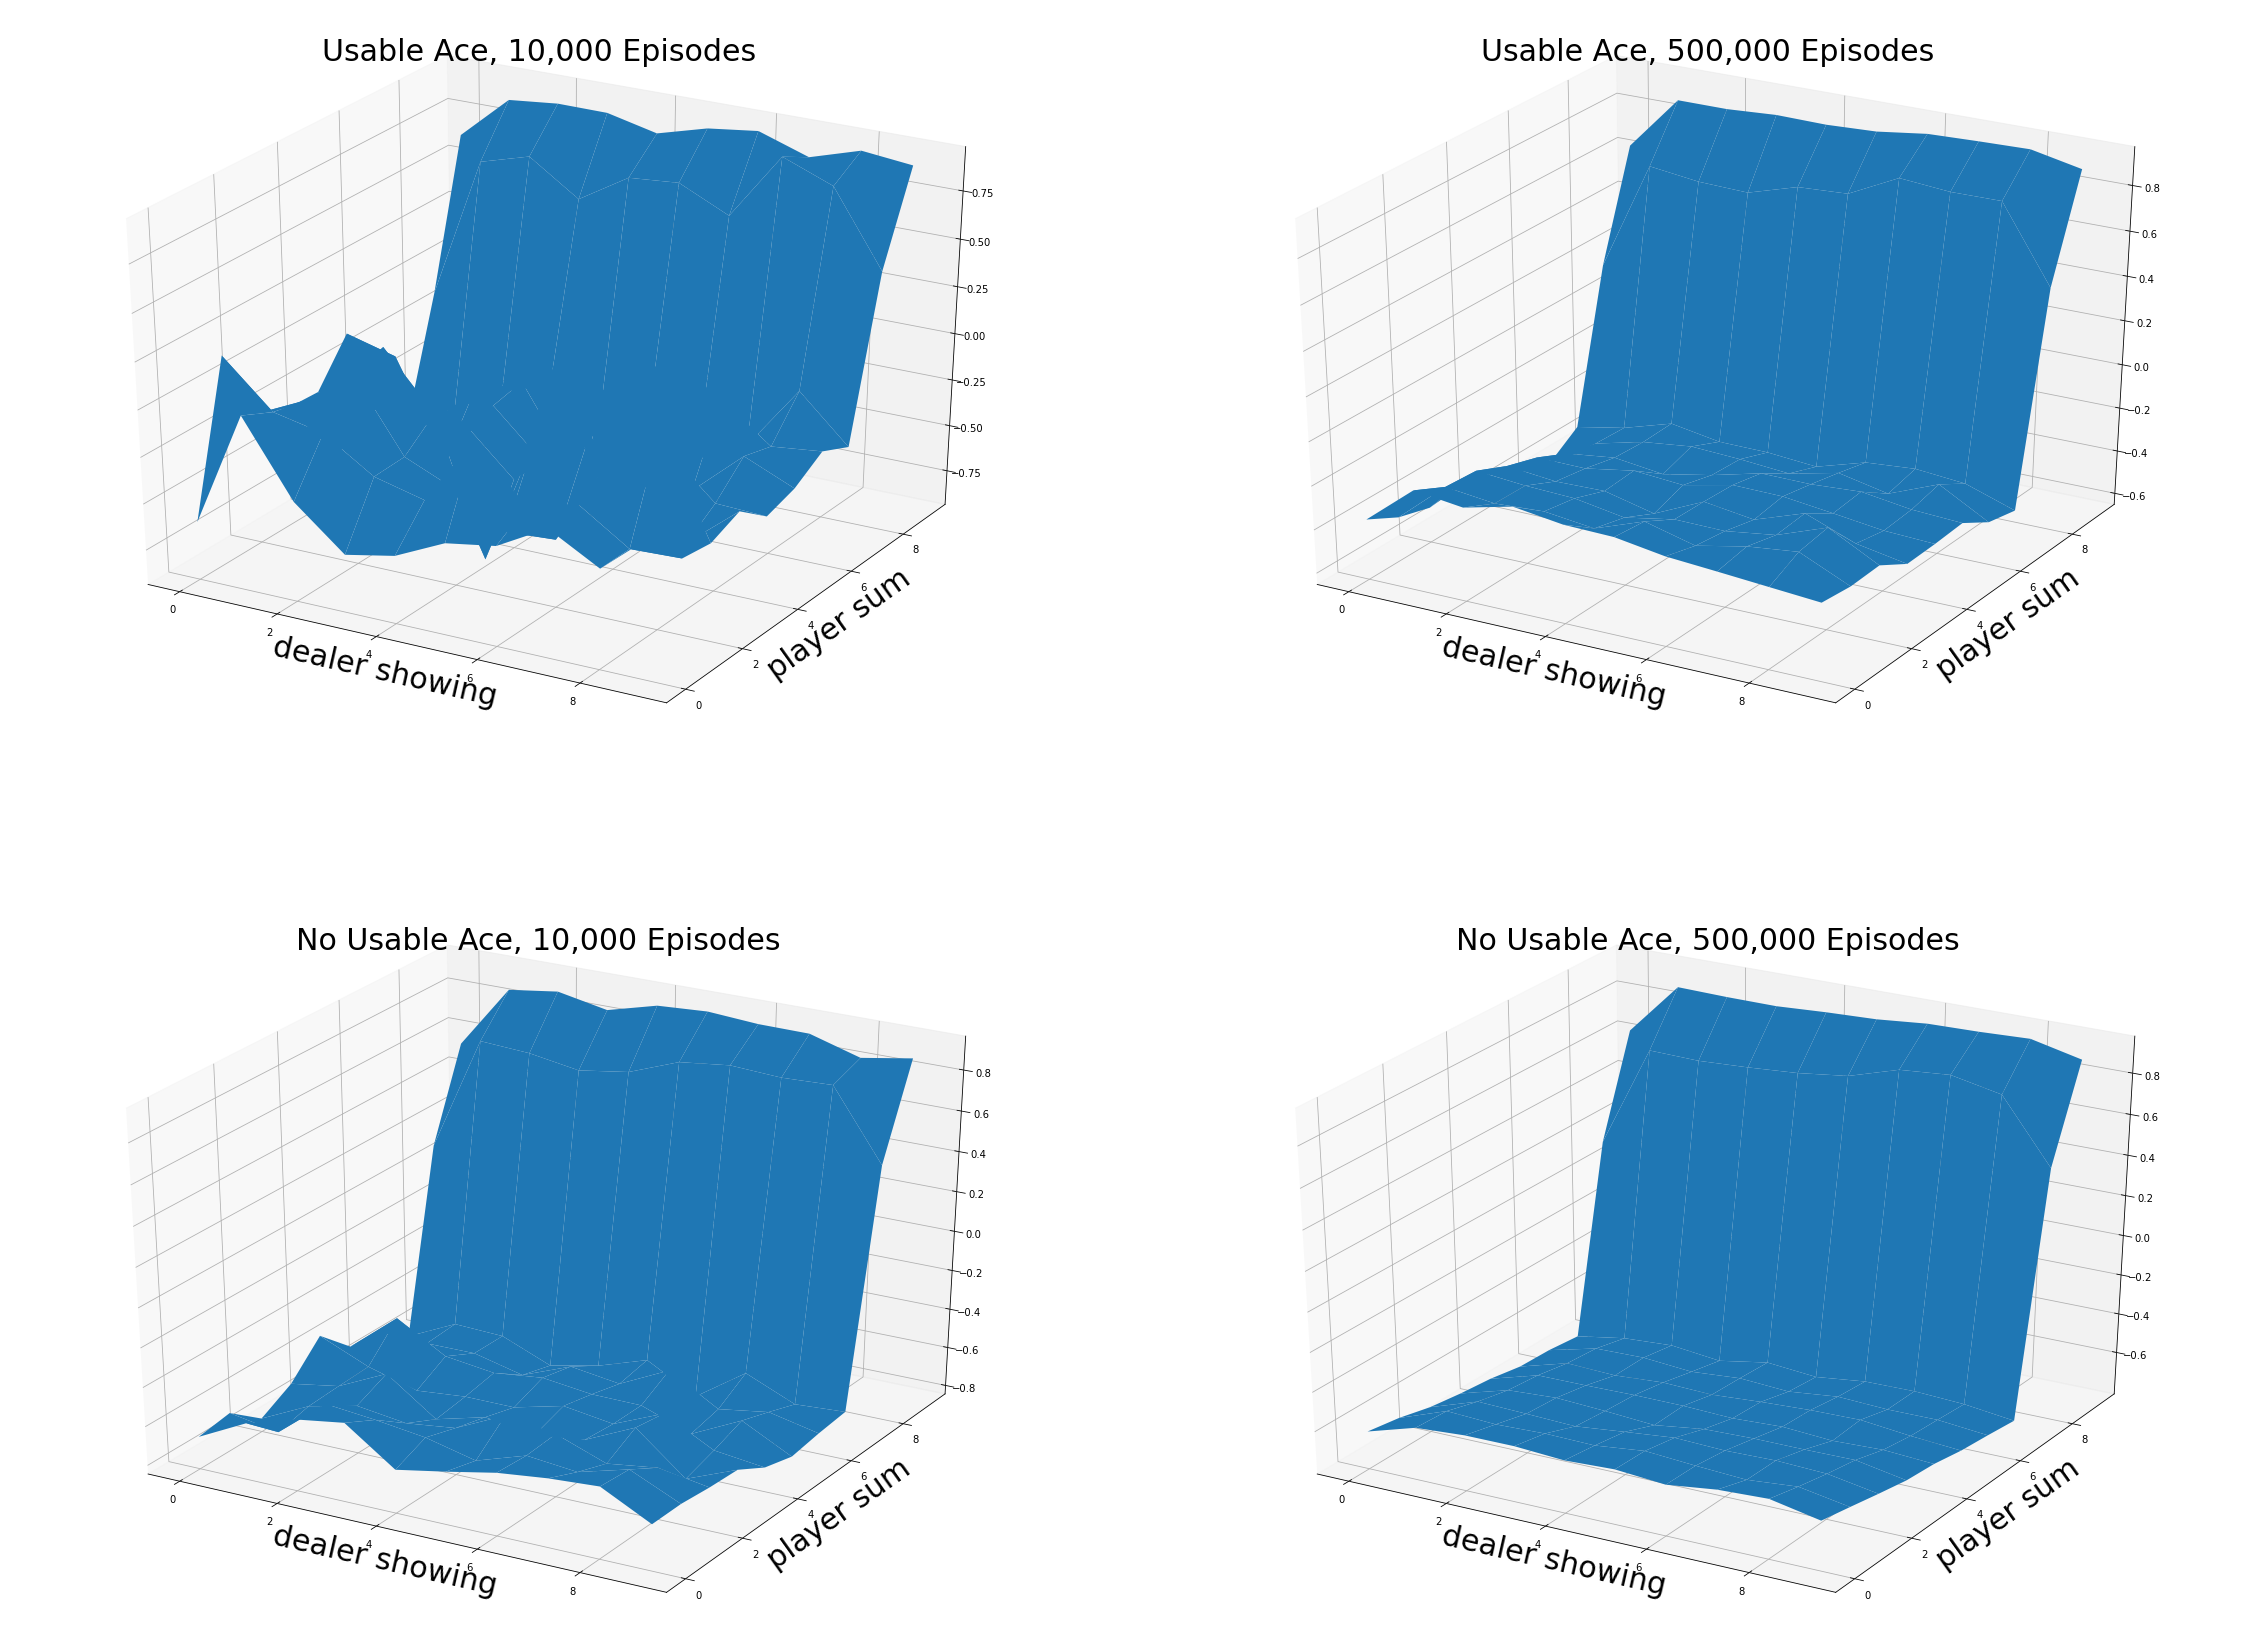

In [15]:
figure_5_1_b()